In [1]:
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.sampling.sampling import LogicSampler
from pybbn.pptc.inferencecontroller import InferenceController

import pandas as pd
import networkx as nx
from networkx.algorithms.dag import topological_sort
from itertools import product

a = BbnNode(Variable(0, 'a', ['on', 'off']), [0.5, 0.5])
b = BbnNode(Variable(1, 'b', ['on', 'off']), [0.5, 0.5, 0.4, 0.6])
c = BbnNode(Variable(2, 'c', ['on', 'off']), [0.7, 0.3, 0.2, 0.8])
d = BbnNode(Variable(3, 'd', ['on', 'off']), [0.7, 0.3, 0.2, 0.8, 0.8, 0.2, 0.3, 0.7])

bbn = (Bbn()
    .add_node(a)
    .add_node(b)
    .add_node(c)
    .add_node(d)
    .add_edge(Edge(a, b, EdgeType.DIRECTED))
    .add_edge(Edge(b, c, EdgeType.DIRECTED))
    .add_edge(Edge(c, d, EdgeType.DIRECTED))
    .add_edge(Edge(b, d, EdgeType.DIRECTED)))

sampler = LogicSampler(bbn)
samples = sampler.get_samples(n_samples=20000, seed=37)

In [2]:
i2n = {n.variable.id: n.variable.name for n in  bbn.get_nodes()}
samples = pd.DataFrame(samples).rename(columns=i2n)

In [3]:
def get_profile(df):
    profile = {}
    for c in df.columns:
        values = sorted(list(df[c].value_counts().index))
        profile[c] = values
    return profile

def get_n2i(parents):
    g = nx.DiGraph()
    for k in parents:
        g.add_node(k)
    for ch, pas in parents.items():
        for pa in pas:
            g.add_edge(pa, ch)
    nodes = list(topological_sort(g))
    return {n:i for i, n in enumerate(nodes)}

def get_cpt(name, parents, n2v, df):
    parents = sorted(parents)
    n2v = {k: sorted(v) for k, v in n2v.items()}
    
    n = df.shape[0]
    
    cpts = []
    if len(parents) == 0:
        for v in n2v[name]:
            c = df[df[name] == v].shape[0]
            p = c / n
            cpts.append(p)
    else:
        domains = [(n, d) for n, d in n2v.items() if n in parents]
        domains = sorted(domains, key=lambda tup: tup[0])
        domain_names = [tup[0] for tup in domains]
        domain_values = [tup[1] for tup in domains]
        domains = list(product(*domain_values))
        
        for values in domains:
            probs = []
            denom_q = ' and '.join([f'{n}=="{v}"' for n, v in zip(domain_names, values)])
            for v in n2v[name]:
                numer_q = f'{name}=="{v}" and {denom_q}'
            
                numer = df.query(numer_q).shape[0] / n
                denom = df.query(denom_q).shape[0] / n
                prob = numer / denom
                probs.append(prob)
            probs = pd.Series(probs)
            probs = probs / probs.sum()
            probs = list(probs)
            cpts.extend(probs)
        
    return cpts

def get_bbn(parents, df):
    n2v = get_profile(df)
    n2i = get_n2i(df)
    n2c = {n: get_cpt(n, parents[n], n2v, df) for n in parents}
    
    bbn = Bbn()
    
    nodes = {}
    for name in n2v:
        idx = n2i[name]
        values = n2v[name]
        cpts = n2c[name]
        
        v = Variable(idx, name, values)
        node = BbnNode(v, cpts)
        nodes[name] = node
        bbn.add_node(node)
        
    for ch, parents in parents.items():
        ch_node = nodes[ch]
        for pa in parents:
            pa_node = nodes[pa]
            
            edge = Edge(pa_node, ch_node, EdgeType.DIRECTED)
            bbn.add_edge(edge)
        
    return bbn

In [4]:
parents = {
    'a': [],
    'b': ['a'],
    'c': ['b'],
    'd': ['c', 'b']
}

In [5]:
bbn1 = get_bbn(parents, samples)

In [6]:
n, d = bbn1.to_nx_graph()

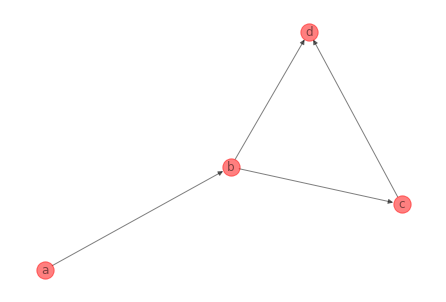

In [7]:
nx.draw(n, with_labels=True, labels=d, node_color='r', alpha=0.5)

In [8]:
join_tree = InferenceController.apply(bbn)

# print the posterior probabilities
for node, posteriors in join_tree.get_posteriors().items():
    p = ', '.join([f'{val}={prob:.5f}' for val, prob in posteriors.items()])
    print(f'{node} : {p}')

b : on=0.45000, off=0.55000
a : on=0.50000, off=0.50000
c : on=0.42500, off=0.57500
d : on=0.46750, off=0.53250


In [9]:
join_tree1 = InferenceController.apply(bbn1)

# print the posterior probabilities
for node, posteriors in join_tree1.get_posteriors().items():
    p = ', '.join([f'{val}={prob:.5f}' for val, prob in posteriors.items()])
    print(f'{node} : {p}')

b : off=0.55085, on=0.44915
a : off=0.49250, on=0.50750
c : off=0.57860, on=0.42140
d : off=0.51557, on=0.48443
